# [Машинное обучение ФБМФ](https://thetahat.ru/)
## Занятие 1 (часть 1): Линейная регрессия

В данном ноутбуке мы рассмотрим несложный пример построения модели линейной регрессии, а также предварительной обработки данных. Для построения моделей и методов обработки данных будем использовать широко известную библиотеку <a target="_blank" href="https://scikit-learn.org/">Scikit-Learn</a> (сокращенно `sklearn`), в которой в удобной форме реализованы многие методы машинного обучения и анализа данных в целом. Более того, принятый интерфейс библиотеки часто используют разработчики других библиотек в силу удобства его использования.

Поставить библиотеку можно командой `pip install scikit-learn`.

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

# обратите внимание, что Scikit-Learn импортируется как sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

import scipy.stats as sps

RANDOM_STATE = 42


### 1. Линейная регрессия на искусственных данных

Рассмотрим задачу обучения модели на искусственных данных, которые генерируются с помощью нелинейной функции с аддитивным шумом.
* Данные описываются функцией  $y = f(x) + \varepsilon$
* $ f(x) = 3x + 4\sin{x} $ — истинная целевая функция
* $\varepsilon$ — аддитивный шум, следующий нормальному распределению $\varepsilon \sim \mathcal{N}(0, 1)$.


В контексте этой задачи, ключевой момент будет заключаться в изучении, насколько линейная регрессия может приблизить этот вид нелинейной зависимости.

In [ ]:
def generate_linear_data(n_samples=100, theta1=3.0, theta2=4.0, X_max=10):
    """
    Генерирует данные для линейной модели y = x * theta1 + sin(x) * theta2  + ε, где ε ~ N(0, 1).

    :param n_samples: Размер генерации.
    :param theta: Коэффициент линейной зависимости.
    :param noise_std: Стандартное отклонение для гауссовского шума.
    :return: Два массива numpy: X и y.
    """

    # Генерация случайных значений для x
    X = np.random.uniform(0, 1, (n_samples, 1)) * X_max  # случайные числа от 0 до X_max
    # Генерация шума
    epsilon = np.random.normal(0, 2, (n_samples, 1))

    # Вычисление y согласно функции
    y = X * theta1 + np.sin(X) * theta2 + epsilon

    return X, y


In [ ]:
n_samples = 60 # количество элементов в выборке
theta1 = 3 # коэффициент для линейной зависимости
theta2 = 4 # коэффициент при sin(x)
X_max = 3 # максимальное значение X

X_grid = np.linspace(0, X_max, n_samples) # равномерная сетка для X от 0 до X_max
X, y = generate_linear_data(n_samples=n_samples, theta1=theta1, theta2=theta2, X_max=X_max)

Визуализируем данные и истинную зависимость $$f(x) = 3x + 4\sin{x}$$

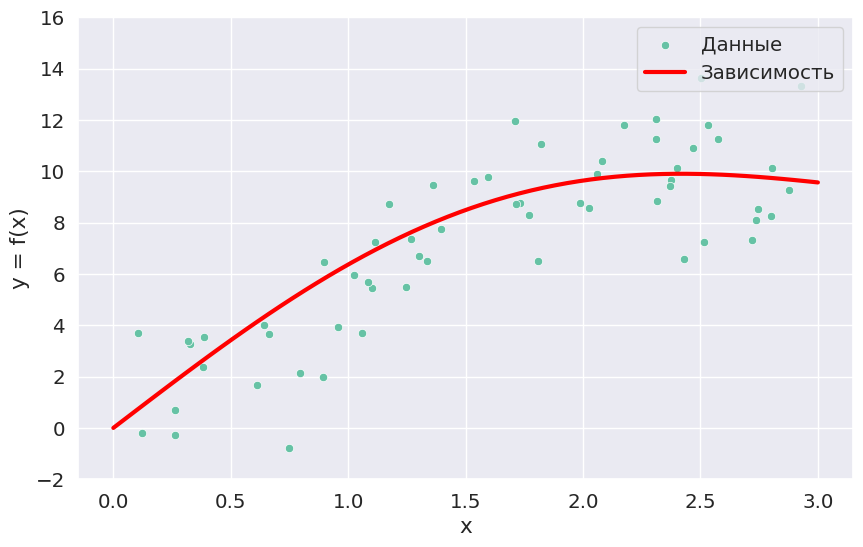

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=X.reshape(-1), y=y.reshape(-1), label="Данные")
sns.lineplot(x=X_grid, y=X_grid*theta1 + np.sin(X_grid) * theta2, c="red", label="Зависимость", linewidth=3)
plt.xlabel("x")
plt.ylabel("y = f(x)")
plt.ylim(-2, 16)

plt.legend(loc="upper right");

Попробуем предсказать значение $y$ по значению $x$, обучив для начала модель линейной регрессии по признаку $X_1 = x$.
Модель линейной регрессии в данном случае имеет вид:
$$
\widehat{y} = \theta_0 + \theta_1 x,
$$
где:
- $ \theta_0 $ — свободный член (intercept),
- $ \theta_1 $ — коэффициент при признаке $ x $.

Модель предполагает, что зависимость между $ x $ и $ y $ линейна. В нашей задаче истинная зависимость нелинейная, поэтому модель линейной регрессии может не дать хорошего приближения.


---
Будем использовать <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">`LinearRegression`</a>.

**Важные аргументы конструктора:**
* `fit_intercept` &mdash; нужно ли включать в модель свободный член. В случае `fit_intercept=True` модели не нужно передавать признак из всех единиц для того, чтобы она оценивала свободный член. По умолчанию `fit_intercept=True`.

**Основные методы класса:**
* `fit(X, y)` &mdash; обучить линейную регрессию на основе данных `X` предсказывать целевой признак `y`. В данном случае под термином "обучить" поднимается вычисление оценки коэффициентов $\widehat{\theta}$.

* `predict(X)` &mdash; предсказать по данным `X` целевой признак `y`. В данном случае под термином "предсказать" поднимается вычисление оценки целевого признака $\widehat{y}$.

Используем `fit_intercept=True` для оценки свободного коэффициента, что позволяет не добавлять в матрицу признаков столбец из единиц.

*Замечание.* О нормализации данных пойдет речь в домашнем задании.

---
Вспомним, как работают методы `fit`, `predict`:

&#x2753; **Вопрос** &#x2753;

> Как получаются оценки параметра $\theta$ и целевого признака в методах `fit` и `predict`?

<details>
  <summary> Кликни для показа ответа </summary>
  
> `fit`

Делает оценку параметра $\theta$, минимизируя среднеквадратичную ошибку между предсказанными значениями $ \hat{y} $  и истинными значениями $y$:

  $$
  \widehat{\theta} = (X^TX)^{-1}X^Ty
  $$

`predict`

Получает оценку целевого признака по формуле:

 $$ \widehat{y} = X\widehat{\theta}$$

</details><br/>

Обучаем модель линейной регрессии на данных, используя только один признак $ x $.


In [ ]:
model = LinearRegression(fit_intercept=True) # объявляем модель
model.fit(X, y) # обучаем на признаке x

LinearRegression()

Оценки свободного коэффициента и theta

In [ ]:
model.intercept_, model.coef_


(array([1.63078451]), array([[3.48872594]]))

Сравним предсказания модели с истинной зависимостью.


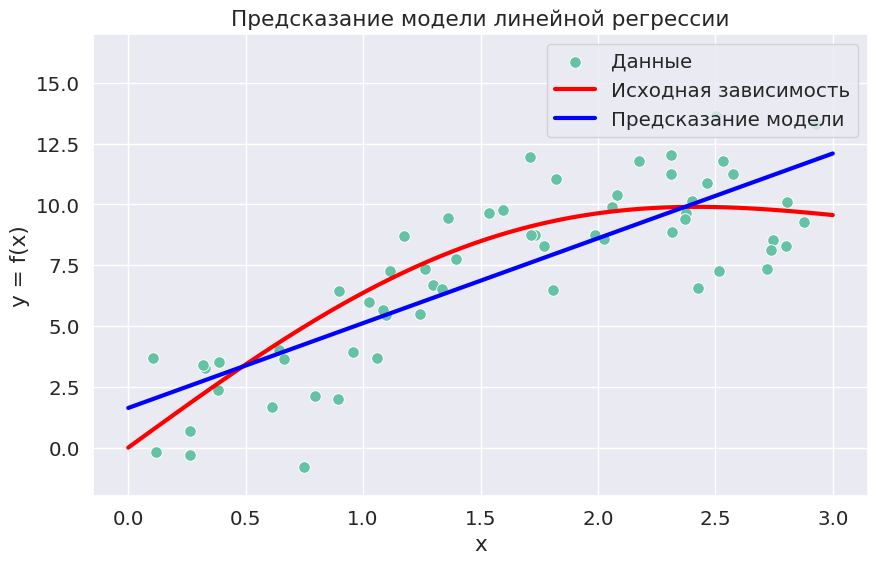

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=X.reshape(-1), y=y.reshape(-1), label="Данные", s=70)
sns.lineplot(x=X_grid, y=X_grid*theta1+np.sin(X_grid)*theta2, c="red", label="Исходная зависимость", linewidth=3)
sns.lineplot(x=X_grid, y=model.predict(X_grid.reshape(-1, 1)).reshape(-1),
             c="blue", label="Предсказание модели", linewidth=3)
plt.title("Предсказание модели линейной регрессии")
plt.xlabel("x")
plt.ylabel("y = f(x)")
plt.ylim(-2, 17)

plt.legend(loc="upper right");

&#x2753; **Вопрос** &#x2753;

> Что можно сделать для увеличения точности предсказаний?

<details>
  <summary> Кликни для показа ответа </summary>
  
>
* Поменять модель на более сложную
* Добавить новые признаки

В данном случае рассмотрим второй вариант

</details><br/>

---
Видим, что исходная зависимость не является линейной, а предсказания модели линейны по X, поэтому такая модель может быть не очень хорошей для наших данных. Попробуем добавить нелинейные признаки и сделать предсказания с их использованием.

Одно нелинейных преобразований - полиномиальное преобразование (в данном случае попробуем использовать признак $X^2$). Добавим $X^2$ в матрицу признаков.

In [ ]:
model = LinearRegression(fit_intercept=True) # объявляем модель

data = pd.DataFrame({
    'X': X.flatten(),
    'X^2': X.flatten() ** 2
}) # создаем новый датасет с использованием X^2

data.head()

,X,X^2
0,2.427948,5.894932
1,2.311164,5.341481
2,1.732206,3.000539
3,1.596715,2.549500
4,2.373738,5.634631


&#x2753; **Вопрос** &#x2753;

> Какой вид будет иметь модель линейной регрессии при добавлении нового признака?

<details>
  <summary> Кликни для показа ответа </summary>
  
>
$$
\widehat{y} = \theta_0 + \theta_1 x + \theta_2 x^2,
$$
</details><br/>



In [ ]:
model.fit(data, y) # обучим модель на новых данных

LinearRegression()

Посмотрим, какие предсказания выдает модель, обученная на данных с полиномиальным признаком.

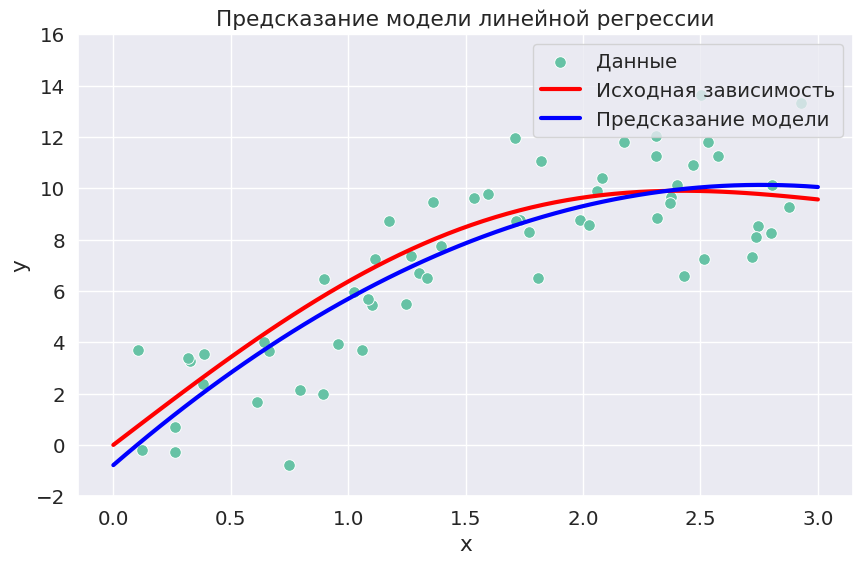

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=X.reshape(-1), y=y.reshape(-1), label="Данные", s=70)
sns.lineplot(x=X_grid, y=X_grid*theta1+np.sin(X_grid)*theta2, c="red", label="Исходная зависимость", linewidth=3)
sns.lineplot(x=X_grid, y=model.predict(pd.DataFrame({'X': X_grid.flatten(), 'X^2': X_grid.flatten() ** 2})).reshape(-1),
             c="blue", label="Предсказание модели", linewidth=3)
plt.title("Предсказание модели линейной регрессии")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-2, 16)

plt.legend(loc="upper right");

По графику видно, что модель, обученная с добавлением признака, лучше приближает исходную зависимость.

**Результаты**
1. Линейная регрессия с одним признаком $ x $ не способна хорошо аппроксимировать нелинейную зависимость.
2. Добавление полиномиального признака $ x^2 $ улучшает качество модели, но всё равно не позволяет точно описать истинную зависимость $ f(x) = 3x + 4\sin{x} $.
3. Для более точного описания данных можно рассмотреть другие нелинейные признаки (например, $ \sin{x} $) или использовать более сложные модели.

### 2. Постановка задачи с использованием реальных данных

Рассмотрим <a href="https://miptstats.github.io/courses/ad_fivt/insurance_miptstats.csv" download="insurance_miptstats.csv" >данные</a> медицинского страхования. В каждой строке представлены признаки для каждого клиента страховой организации.

В данных содержатся следующие признаки:
* `birthday` &mdash; день рождения (*в версии Физтех.Статистики; в оригинальной версии `age` &mdash; возраст*);
* `sex` &mdash; пол, возможные значения: `female`, `male`;
* `bmi`  &mdash; соотношение массы тела квадрату его высоты (body mass index), измеряется в кг/м$^2$, хорошие значения лежат в диапазоне от 18.5 до 24.9;
* `children` &mdash; количество детей;
* `smoker` &mdash; курит ли клиент;
* `region` &mdash; район в США, возможные значения: `northeast`, `southeast`, `southwest`, `northwest`;
* `charges` &mdash; индивидуальные медицинские расходы, оплачиваемые медицинским страхованием.

**Задача:** предсказать *индивидуальные медицинские расходы* по остальным признакам.\
\
Это может быть полезно для таких целей:
  
- **Определение оптимальных взносов:** На основании предсказанных медицинских расходов компании могут устанавливать размер страховых взносов таким образом, чтобы они покрывали ожидаемые траты.
- **Оптимизация страховок:** Определять, какие группы населения более подвержены высоким расходам, и разрабатывать продукты и тарифы, которые лучше обслуживают эти сегменты рынка.
- **Осведомленность и планирование:** Пациенты могут использовать информацию, чтобы понять, как их образ жизни и личные характеристики могут влиять на будущие медицинские расходы, и предпринять шаги по их снижению, например, прекращение курения или поддержание здорового веса.




Оригинальные данные можно посмотреть на <a target="_blank" href="https://www.kaggle.com/mirichoi0218/insurance">Kaggle</a>.

Загрузим данные

In [ ]:
data = pd.read_csv('./insurance_miptstats.csv', parse_dates=[0])
data.head()

,birthday,sex,bmi,children,smoker,region,charges
0,2001-12-20,female,27.900,0,yes,southwest,16884.92400
1,2003-03-18,male,33.770,1,no,southeast,1725.55230
2,1992-11-02,male,33.000,3,no,southeast,4449.46200
3,1987-07-27,male,22.705,0,no,northwest,21984.47061
4,1988-11-04,male,28.880,0,no,northwest,3866.85520


Посмотрим на размер таблицы

In [ ]:
data.shape

(1338, 7)

Тестировать качество построенной модели всегда нужно на данных, которые не участвовали в обучении. Такие данные называются *тестовыми*. Данные, которые участвуют в обучении, называются *обучающими*.

Выполнить **разбиение на обучающие и тестовые данные** можно с помощью функции <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">`train_test_split`</a>, которая имеет следующий синтаксис:

`sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)`

**Аргументы:**

- `*arrays` &mdash; входные данные, которые должны быть разделены. Можно передавать несколько объектов.
- `test_size` &mdash; размер тестовых данных, может быть задан как в относительных единицах от общего объема данных, тогда значение в диапазоне от 0 до 1, так и в количественных, то есть количество объектов. Если не указан, то дополняет `train_size`, если о он не указан, то принимается значение 0.25.
- `train_size` &mdash; размер тестовых данных, может быть задан как в относительных единицах от общего объема данных, тогда значение в диапазоне от 0 до 1, так и в количественных, то есть количество объектов. Если не указан, то дополняет `test_size`.
- `random_state` &mdash; можно указать для воспроизводимости экспериментов.
- `shuffle` &mdash; перемешивать ли выборку. Если `False`, то аргумент `stratify` должен быть установлен в None.
- `stratify` &mdash; если задан, то метод разбивает на трейн и тест так, чтобы отношение данных разных классов в подвыборках было одинаковым.

Применим эту функцию к нашим данным, отнеся в тестовую часть 20% данных, а в обучающую &mdash; остальные 80%. Поскольку мы использовали параметры по умолчанию, то исходные данные сначала были перемешаны, а затем разделены.

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train.shape, test.shape

((1070, 7), (268, 7))

### 3. Обучение

Сразу приведем временной признак, а именно, построим из него признак, отвечающий за возраст человека. Дробные значения отбрасывать смысла нет. При выполнении преобразования учитываем, <a href="https://miptstats.github.io/courses/python/08_pandas1.html#5.-Интервалы-времени">как в `pandas` можно работать с интервалами времени</a>.

*Примечание.* Данную операцию можно было выполнить сразу для всех данных. Но лучше так не делать, поскольку в других примерах таким способом иногда можно "подглядеть" в тестовые данные.

In [ ]:
train['age'] = (pd.Timestamp('2024-04-17') - train['birthday']) / pd.Timedelta(days=365)

Выделим категории признаков

In [ ]:
categorial_features = ['sex', 'smoker', 'region']  # категориальные признаки
real_features = ['age', 'bmi', 'children']  # вещественные признаки
target_feature = 'charges'  # целевой признак

Посмотрим на визуализацию совместных распределений вещественных признаков при помощи <a href="https://miptstats.github.io/courses/python/09_seaborn.html#6.-PairGrid">`PairGrid`</a>, причем будем разбивать данные по одному признаку из числа категориальных. На графиках приведены:
* данные в виде точек для каждой пары вещественных признаков;
* ядерные оценки плотности для каждой пары вещественных признаков;
* ядерные оценки плотности для всех вещественных признаков по отдельности.

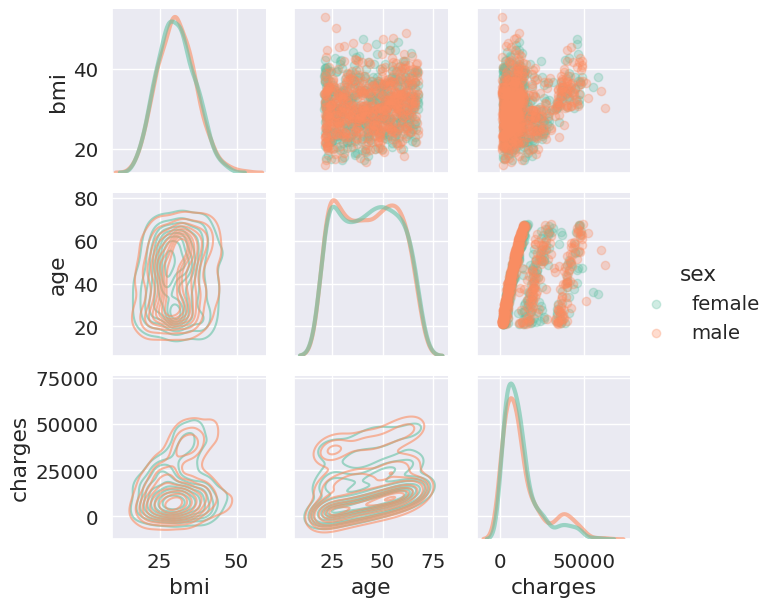

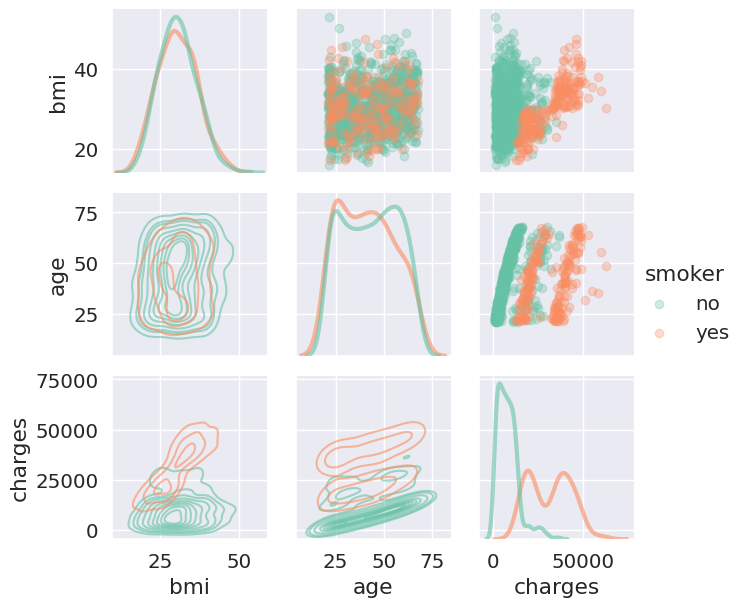

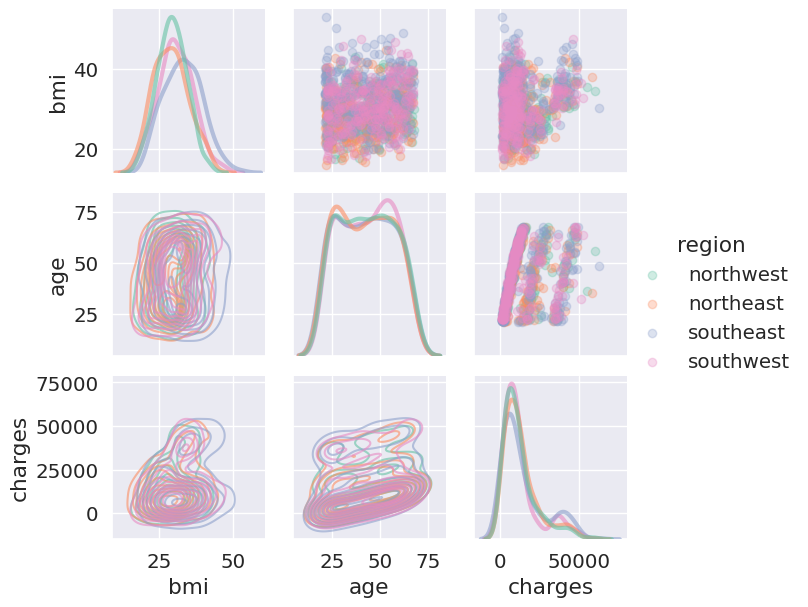

In [ ]:
for hue in categorial_features:
    g = sns.PairGrid(train[['bmi', 'age', 'charges', hue]],
                     hue=hue, diag_sharey=False, height=3)

    g.fig.set_size_inches(6,6)
    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_upper(plt.scatter, alpha=0.3)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6,
               common_norm=False)  # каждая плотность по отдельности должна давать 1 при интегрировании

    g.add_legend()

По графикам сразу можно сделать следующие выводы:
* расходы растут с увеличением возраста клиента;
* величина расходов больше для курящих людей.

Видимо, эти признаки должны оказать существенное влияние при построении регрессионной модели.

---
Напомним, как работают методы `fit` и `predict`:



 `fit`

Делает оценку параметра $\theta$, минимизируя среднеквадратичную ошибку между предсказанными значениями $ \hat{y} $  и истинными значениями $y$:

  $$
  \widehat{\theta} = (X^TX)^{-1}X^Ty
  $$

`predict`

Получает оценку целевого признака по формуле:

 $$ \widehat{y} = X\widehat{\theta}$$

---
Теперь попробуем обучить модель линейной регрессии, используя различные наборы признаков



### Признак **age**

In [ ]:
model = LinearRegression(fit_intercept=True) # объявляем модель
model.fit(train[['age']], train[target_feature]) # обучаем на признаке age

LinearRegression()

Выполним преобразование для получения возраста на тестовых данных. Напомним еще раз, что некоторые преобразования можно было сделать со всеми данными, это было бы корректно. Однако во избежании ошибок в будущем рекомендуем определять преобразования только по обучающим данным, а затем применять их для тестовых.

In [ ]:
# Получаем возраст клиента по дате рождения
test['age'] = (pd.Timestamp('2024-04-17') - test['birthday']) / pd.Timedelta(days=365)

Получим предсказание модели для тестовых данных

In [ ]:
y_pred = model.predict(test[['age']])

Выведем коэффициент, полученный при обучении модели регресии

In [ ]:
print(model.coef_[0].round(2))

240.47


&#x2753; **Вопрос** &#x2753;

> Как можно интерпретировать значение коэффициентов в модели линейной регрессии?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Коэффициент в линейной регрессии равен изменению таргета при изменении признака на 1. **Численно это значит, что в данной модели при увеличении возраста человека на 1 год предсказание затрат увеличивается на ~ 240. С каждым прожитым годом предполагаемые затраты увеличиваются**

</details><br/>

In [ ]:
pred33 = model.predict(pd.DataFrame({'age': [33]}))[0]
pred34 = model.predict(pd.DataFrame({'age': [34]}))[0]
print(f'Предсказание расходов для человека 33х лет: {pred33}')
print(f'Предсказание расходов для человека 34х лет: {pred34}')

Предсказание расходов для человека 33х лет: 10968.471003422404
Предсказание расходов для человека 34х лет: 11208.941066514344


### Признак **bmi**

In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(train[['bmi']], train[target_feature])
y_pred = model.predict(test[['bmi']])

print(f"Bmi coefficient: {model.coef_[0].round(2)}")

Bmi coefficient: 392.44


По предсказанию модели при увеличении индекса массы тела на 1 расходы увеличиваются на ~392

### Признаки **bmi** и **age**

In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(train[['bmi', 'age']], train[target_feature])
y_pred = model.predict(test[['bmi', 'age']])

Выведем коэффициенты

In [ ]:
print(model.coef_)

[330.40058921 223.55689301]


Изменение индекса массы тела на 1 приводит к большему изменению предсказания медицинских затрат в данной модели, чем изменение возраста на 1 год. Численные значения изменений в зависимости от увеличения bmi/age на 1 будут в точности равны соответствующим коэффициентам в данной модели.

Рассмотрим предказания медицинских затрат для объекта:

* **age = 20, bmi = 18** \

И со сдвигом на единицу по одному или обоим признакам:
* **age = 21, bmi = 19**
* **age = 20, bmi = 19**
* **age = 21, bmi = 18**

In [ ]:
objects = pd.DataFrame({'bmi': [18, 19, 19, 18],
                        'age': [20, 21, 20, 21]})
preds =  model.predict(objects)
objects['charges_predicted'] = preds

objects

,bmi,age,charges_predicted
0,18,20,4079.495688
1,19,21,4633.453171
2,19,20,4409.896278
3,18,21,4303.052581


Посмотрим на визуализацию

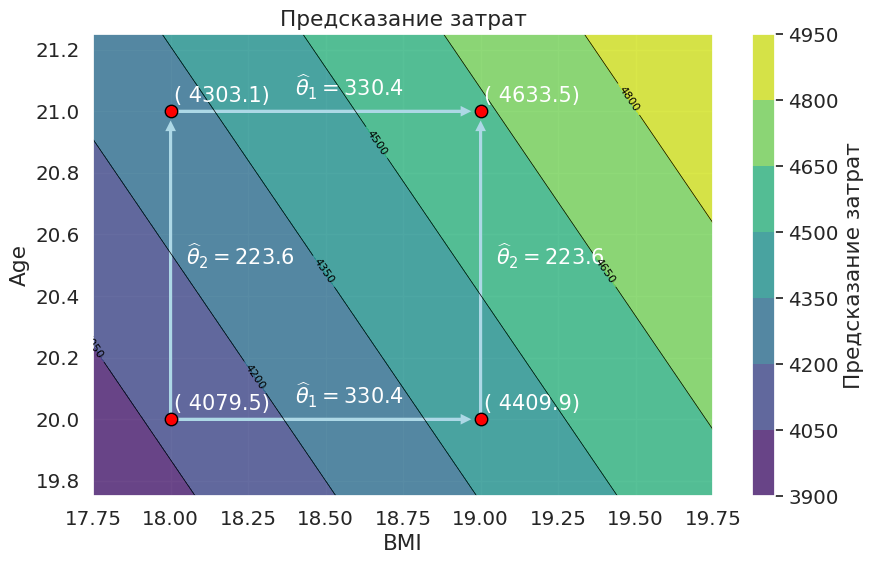

In [ ]:
# Грид для предсказаний
bmi_range = np.linspace(17.75, 19.75, 200)
age_range = np.linspace(19.75, 21.25, 200)
bmi_grid, age_grid = np.meshgrid(bmi_range, age_range)
pred_grid = model.predict(pd.DataFrame({'bmi': bmi_grid.ravel(),
                           'age': age_grid.ravel()})).reshape(bmi_grid.shape)

# Визуализация
plt.figure(figsize=(10, 6))

# Заполненные контуры
contourf = plt.contourf(bmi_grid, age_grid, pred_grid, cmap='viridis', alpha=0.8)

# Линии контуров
contour = plt.contour(bmi_grid, age_grid, pred_grid, colors='black', linewidths=0.5)

# Цветовая шкала
cbar = plt.colorbar(contourf)
cbar.set_label('Предсказание затрат')

# Отображение признаков

plt.scatter(objects['bmi'], objects['age'], color='red', edgecolor='black', zorder=5, s=80)
for i, row in objects.iterrows():
    plt.text(row['bmi'] + 0.01, row['age'] + 0.03,
             f"( {row['charges_predicted']:.1f})",
             fontsize=15, ha='left', color='white', zorder=6)

# Add arrows with labels indicating changes in theta
plt.arrow(18, 20, 1 - 0.06, 0, head_width=0.02, head_length=0.02, fc='lightblue', ec='lightblue', linewidth=2)
plt.text(18.5 - 0.1, 20.05, rf'$\widehat{{\theta}}_1 = {model.coef_[0]:.1f}$', fontsize=15, color='white')

plt.arrow(18, 20, 0, 1 - 0.06, head_width=0.02, head_length=0.02, fc='lightblue', ec='lightblue', linewidth=2)
plt.text(18.05, 20.5, rf'$\widehat{{\theta}}_2 = {model.coef_[1]:.1f}$', fontsize=15, color='white')

plt.arrow(18, 21, 1 - 0.06, 0, head_width=0.02, head_length=0.02, fc='lightblue', ec='lightblue', linewidth=2)
plt.text(18.5 - 0.1, 21.05, rf'$\widehat{{\theta}}_1 = {model.coef_[0]:.1f}$', fontsize=15, color='white')

plt.arrow(19, 20, 0, 1 - 0.06, head_width=0.02, head_length=0.02, fc='lightblue', ec='lightblue', linewidth=2)
plt.text(19.05, 20.5, rf'$\widehat{{\theta}}_2 = {model.coef_[1]:.1f}$', fontsize=15, color='white')


# Подписи осей
plt.title('Предсказание затрат')
plt.xlabel('BMI')
plt.ylabel('Age')

# Добавление подписей к линиям контуров
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')

plt.show()

Точки представляют собой людей возраста 20/21 и bmi 18/19. Стрелки показывают, куда переходит точка при увеличении age/bmi на 1 и изменение предполагаемых медицинских затрат.

По графику видно, что изменение индекса массы тела на 1 дает больший прирост (`+320.08 к предсказанию затрат на медицину`) к предскаазанию затрат, чем изменение возраста на 1 (`+240.33 к предсказанию`)

Таким образом, коэффициенты в линейной регрессии позволяют количественно оценить влияние каждого признака на предсказание.

---
**Обработка категориальных признаков**

Далее **закодируем категориальные признаки** с помощью класса <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">`OneHotEncoder`</a>. Напомним, данный метод из одного категориального признака делает несколько бинарных признаков по количеству различных значений исходного категориального признака. Например, если исходный признак принимал 5 различных значений, то его кодировкой будет 5 новых бинарных признаков, где единица будет только у того бинарного признака, который соответствует данному значению исходного категориального признака. Иногда, *например, для линейной регрессии*, необходимо делать на один бинарный признак *меньше*, поскольку значения оставшегося бинарного признака можно выразить из значений всех остальных бинарных признаков.

**Важные аргументы конструктора:**
* `categories` &mdash; если установлено значение `auto`, то категории определяются по имеющемуся объему данных, иначе, используется список категорий, который передается этим аргументом.
* `drop` &mdash; указывает методику, используемую для удаления одной из категорий для каждого объекта. Это может быть полезно для некоторых моделей, например, для линейной регрессии. Возможные значения указаны далее.
  * `None` &mdash; оставляем все признаки.
  * `'first'` &mdash; удаляет первую категорию для каждого признака. Если признак имеет одну категрию, то он будет удален полностью.
  * `'if_binary'` &mdash; удаляет первую категорию только для бинарных признаков.
  * массив`drop`, где `drop[i]` &mdash; категория в признаке feature `X[:, i]`, которая должна быть удалена.
* `sparse_output` &mdash; возвращает sparse-матрицу, если установлено значение `True`, иначе &mdash; массив.

**Основные методы класса:**
* `fit(X)` &mdash; обучить кодировщик кодировать признаки на основе данных `X`. В данном случае под термином "обучить" поднимается определение функций кодирования и декодирования признаков.
* `transform(X)` &mdash; закодировать признаки в данных `X`.
* `fit_transform(X)` &mdash; обучить кодировщик по данным `X` и сразу их закодировать.
* `inverse_transform(X)` &mdash; декодировать признаки в данных `X`, то есть перевести бинарные признаки в исходные категориальные.

---

При построении кодировщика для наших данных учтем ряд особенностей:
* указываем `drop='first'`, то есть одну категорию нужно исключить;
* указываем `sparse_output=False`, то есть вернуть нужно неразреженную матрицу;
* нужно выполнить *обучение*, что в данном случае подразумевает построение и сохранение правила преобразования;
* сразу же кодируем признаки из обучающего множества;

In [ ]:
encoder = OneHotEncoder(drop='first', sparse_output=False)  # объявляем модель
train_cat = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_cat

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1.]])

Можем посмотреть на то, как у нас "обучились" категории. Для каждого категориального признака приведен список его категорий

In [ ]:
encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

Соединим вместе вещественные признаки и закодированные категориальные

In [ ]:
X_train = np.hstack([train[real_features], train_cat])
X_train.shape

(1070, 8)

Обучим модель, используя категориальные и вещественные признаки

In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, train[target_feature])

LinearRegression()

Посмотрим на результат обучения. Оценки коэффициентов перед признаками

In [ ]:
model.coef_

array([  257.14354577,   336.56325568,   423.94099187,   -25.48434935,
       23656.64811639,  -370.88646373,  -659.67773002,  -818.2905385 ])

Оценка свободного коэффициента

In [ ]:
model.intercept_

-12822.959552953498

### 4. Тестирование и оценка качества

Пусть мы обучили конкретную модель и можем получать предсказания таргета. Для оценки качества полученных предсказаний можно использовать различные функционалы ошибки и функционалы качества. Далее рассмотрим некоторые из них

In [ ]:
# Кодируем категориальные признаки с помощью метода transform обученного ранее кодировщика
test_cat = encoder.transform(test[categorial_features])

# Соединяем данные
X_test = np.hstack([test[real_features], test_cat])

Выполним *предсказание* построенной ранее моделью с помощью метода `predict`

In [ ]:
test_preds = model.predict(X_test)

Посчитать **ошибку предсказания** можно разными способами. Наиболее популярный способ &mdash; **метрика MSE** (*mean squared error*). Пусть $Y_1, ..., Y_n$ &mdash; истинные значения, а $\widehat{Y}_1, ..., \widehat{Y}_n$ &mdash; предсказания. Тогда метрика MSE определяется как
$$MSE = \frac{1}{n}\sum_{i=1}^n \left(Y_i - \widehat{Y}_i\right)^2.$$

*Замечание.* В анализе данных функционалы качества и функционалы ошибки предсказания принято называть метриками. Данные метрики не имеют никакого отношения к функциям расстояния, в качестве которых термин "метрика" используется в математическом анализе.

Посчитаем ее, а точнее &mdash; корень из нее, который еще обозначается как RMSE (*root MSE*)

In [ ]:
np.sqrt(((test[target_feature] - test_preds) ** 2).mean())

5793.112670753037

Это значение уже имеет конкретный смысл  &mdash; насколько в среднем модель отклоняется от истинного значения. То есть в среднем отклонения предсказания величины страховых расходов имеют порядок 6 000 условных единиц. Напомним, что в данных страховые расходы в основной массе принимают значения до 50 000 у.е..

Готовая <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">реализация</a> также есть в `sklearn`:

In [ ]:
metrics.mean_squared_error(test[target_feature], test_preds) ** 0.5

5793.112670753037

---
Другой вариант &mdash; метрика **MAE** (*mean absolute error*), определяемая как
$$MAE = \frac{1}{n}\sum_{i=1}^n \left|Y_i - \widehat{Y}_i\right|.$$

Ее большое преимущество в том, что она не сильно подстраивается по выбросы по сравнению с MSE. Однако ее труднее оптимизировать.

In [ ]:
metrics.mean_absolute_error(test[target_feature], test_preds)

4180.120715743264

---
Еще один популярный вариант &mdash; метрика **MAPE** (*mean absolute percentage error*), определяемая как
$$MAPE = 100\% \cdot \frac{1}{n}\sum_{i=1}^n \frac{\left|Y_i - \widehat{Y}_i\right|}{Y_i}.$$

В отличии от предыдущих метрик она позволяет посчитать ошибку *в процентах*, что бывает достаточно информативно в реальных задачах.

Реализуем ее

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

Посчитаем для ее для наших данных

In [ ]:
mean_absolute_percentage_error(test[target_feature], test_preds)

46.8704570818819

---
Еще для измерения качества модели можно использовать **коэффициент детерминации $ R^2 $**, который также часто используется для оценки качества предсказательной модели. Этот коэффициент измеряет, какую долю дисперсии зависимой переменной модель сумела объяснить.


Коэффициент детерминации $R^2$ рассчитывается как:

$$
R^2 = 1 - \frac{\sum_{i=1}^n (Y_i - \widehat{Y}_i)^2}{\sum_{i=1}^n (Y_i - \overline{Y})^2},
$$

где
- $\sum_{i=1}^n \left(Y_i - \widehat{Y}_i\right)^2$ — сумма квадратов ошибок (SSE)
- $\overline{Y} = \frac{1}{n} \sum_{i=1}^n Y_i$ — среднее из всех истинных значений
- $\sum_{i=1}^n \left(Y_i - \overline{Y}\right)^2$ — полная сумма квадратов (SST)

&#x2753; **Вопрос** &#x2753;

> Чему равно значение метрики $R^2$ для "идеальной модели"?

<details>
  <summary> Кликни для показа ответа </summary>
  
> $R^2$ = 1


Интерпретация $R^2$

- $R^2 = 1$: Такая модель объясняет всю дисперсию данных (идеальный случай).
- $R^2 = 0$: Модель не объясняет дисперсию данных лучше, чем просто среднее значение $Y$.
- $R^2 < 0$: Модель объясняет дисперсию хуже, чем простая модель без регрессии (может случиться, если модель переобучается или плохо подходит для использования на конкретных данных).

</details><br/>





Для сравнения посчитаем предсказания и ошибки на обучающем и тестовом множествах.

In [ ]:
def get_regression_metrics_df(y_true, y_pred):
    """
    Вычисляет метрики качества регрессионной модели: RMSE, MAE, MAPE
    и выводит их в виде pandas DataFrame.

    Параметры:
    y_true -- истинные значения целевой переменной.
    y_pred -- предсказанные значения целевой переменной.

    Возвращает:
    DataFrame с метриками.
    """
    # Вычисление метрик
    rmse = metrics.mean_squared_error(y_true, y_pred) ** 0.5
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)


    # Создание DataFrame
    metrics_df = pd.DataFrame({
        "Метрика": ["Root Mean Squared Error (RMSE)",
                    "Mean Absolute Error (MAE)",
                    "Mean Absolute Percentage Error (MAPE)",
                    "R2 Score"],
        "Значение": [rmse, mae, mape, r2],
    })

    return metrics_df


Метрики для тестовой выборки

In [ ]:
test_preds = model.predict(X_test)

metrics_df = get_regression_metrics_df(test[target_feature], test_preds)
metrics_df

,Метрика,Значение
0,Root Mean Squared Error (RMSE),5793.112671
1,Mean Absolute Error (MAE),4180.120716
2,Mean Absolute Percentage Error (MAPE),46.870457
3,R2 Score,0.783830


Метрики для обучающей выборки

In [ ]:
train_preds = model.predict(X_train)

metrics_df = get_regression_metrics_df(train[target_feature], train_preds)
metrics_df

,Метрика,Значение
0,Root Mean Squared Error (RMSE),6105.021537
1,Mean Absolute Error (MAE),4208.139727
2,Mean Absolute Percentage Error (MAPE),42.207078
3,R2 Score,0.741770


Мы видим, что на обучающем множестве значения ошибок предсказания получились немного меньше, чем на тестовом множестве. Это и понятно, ведь наша модель так построена по обучающим данным, чтобы давать на них наименьшую ошибку. На данных, которые она "не видела" при обучении, она может вычислять предсказания несколько хуже. В этом и есть причина разделения данных на обучающую и тестовую часть.

Не редко случается так, что на обучающих данных модель ошибается гораздо меньше, чем на тестовых. Такую ситуацию еще называют **переобучением**. Простой пример &mdash; студент, который готовится к экзамену только за пару дней до него исключительно по билетам, не занимаясь при этом по предмету в течении семестра. Он может хорошо ответить по билетам на экзамене, ведь именно по ним он обучился. Однако, опыт показывает, что знания по каким-то другим вопросам оказываются значительно хуже, не говоря уже о применении полученных знаний в реальной практике.

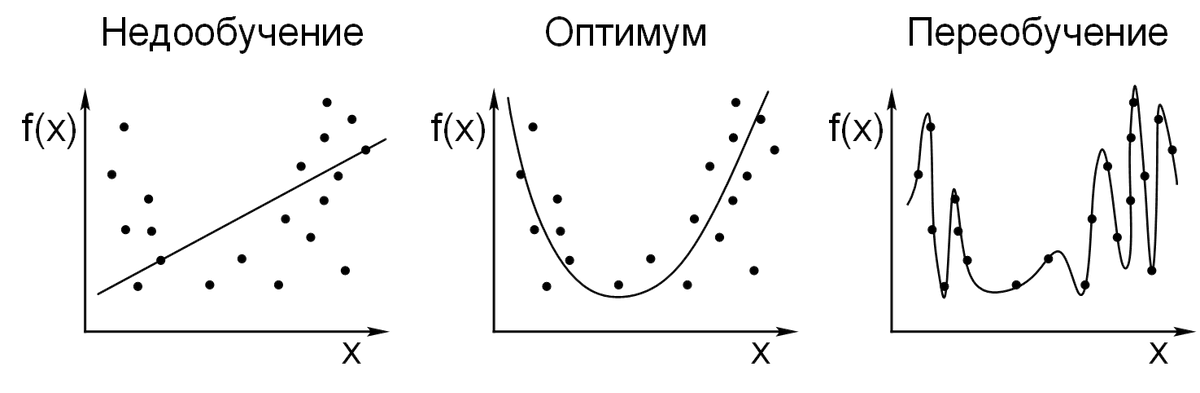

### 5. Преобразование признаков

Выше мы могли получить только линейную зависимость от исходных признаков, поэтому может быть полезно добавить преобразования признаков, чтобы в результате модель могла бы предсказывать более сложные зависимости.

Список преобразований, которые могут быть полезны при обучении регрессии:

1. **Стандартизация данных**. Пусть $x_{ij}$ &mdash; значение признака $j$ для объекта $i$. Обозначим $m_j$ &mdash; выборочное среднее значение признака $j$ (функция `np.mean`), а $s^2_j$ &mdash; выборочную дисперсию признака $j$ (функция `np.var`). Тогда стандартизацией является преобразование
$$\widetilde{x}_{ij} = \frac{x_{ij} - m_j}{s_j}.$$





2. Добавление нелинейности с помощью **полиномиалных признаков**
Создание новых признаков как полиномиальных комбинаций исходных. Полиномиальная регрессия может улучшить модель, если данные обладают нелинейными взаимозависимостями.

  

3. Логарифмирование
4. Обработка выбросов


Попробуем для текущей задачи подобрать нелинейное преобразование, которое поможет улучшить качество предсказания.




Посмотрим еще раз на индекс массы тела и курение:

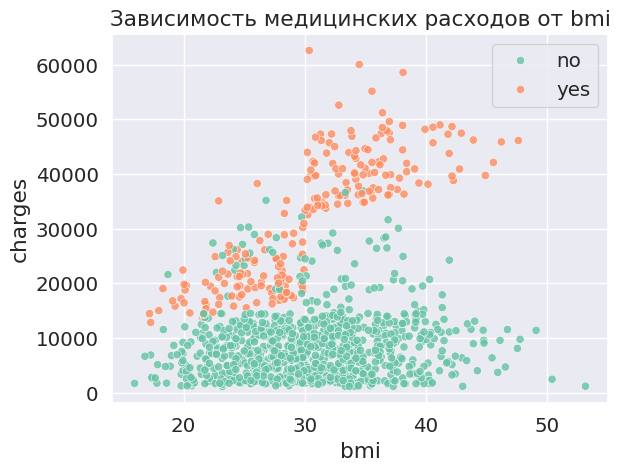

In [ ]:
plt.plot(figsize=(10, 6))

sns.scatterplot(x=train['bmi'], y=train['charges'], hue=train['smoker'], alpha=0.8)

plt.title('Зависимость медицинских расходов от bmi')
plt.legend(loc='upper right');

Предсказание модели для данных

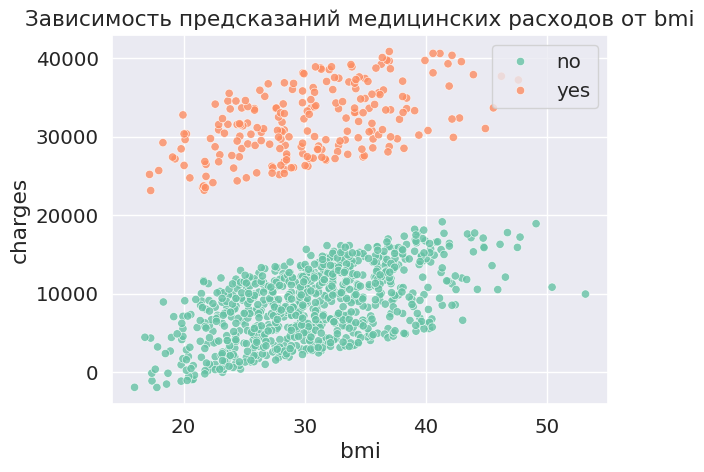

In [ ]:
plt.plot(figsize=(10, 6))

sns.scatterplot(x=train['bmi'], y=model.predict(X_train), hue=train['smoker'], alpha=0.8)

plt.ylabel('charges')
plt.title('Зависимость предсказаний медицинских расходов от bmi')
plt.legend(loc='upper right');

Видим, что в предсказаниях charges увеличивается на один и тот же коэффициент при росте bmi на 1.

На графике с реальными данными можно увидеть, что зависимость расходов от bmi различаются в зависимости от признака `smoker`. Есть предположение, что при добавлении признака `[smoker * bmi]` можно будет улучшить предсказания для объектов со значением smoker = "yes".

In [ ]:
# для обучающей выборки
train['smoker_bmi'] = (train['smoker'] == 'yes') * train['bmi']


# для тестовой выборки
test['smoker_bmi'] = (test['smoker'] == 'yes') * test['bmi']

real_features.extend(['smoker_bmi'])

Обучим модель с новыми признаками

In [ ]:
X_train = np.hstack([train[real_features], train_cat])
X_test = np.hstack([test[real_features], test_cat])

model = LinearRegression(fit_intercept=True)
model.fit(X_train, train[target_feature])

LinearRegression()

Посмотрим на предсказания модели с новым признаком.

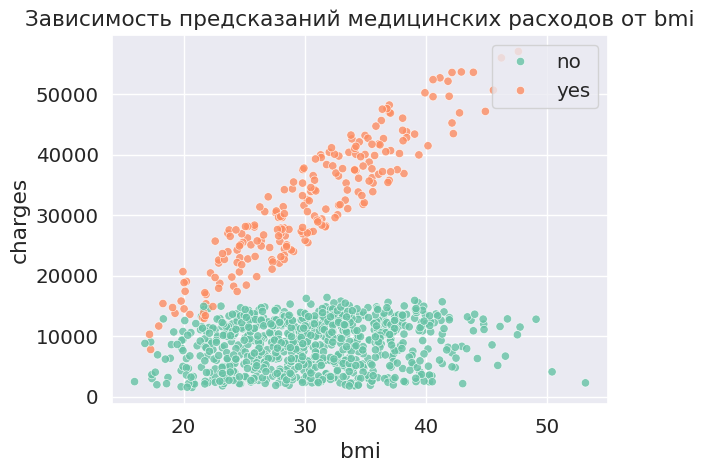

In [ ]:
plt.plot(figsize=(10, 6))

sns.scatterplot(x=train['bmi'], y=model.predict(X_train), hue=train['smoker'], alpha=0.8)

plt.ylabel('charges')
plt.title('Зависимость предсказаний медицинских расходов от bmi')
plt.legend(loc='upper right');

Теперь можно увидеть, что при увеличении bmi на 1, charges меняется на значение, которое зависит от признака smoker, т.е. модель учла эту зависимость.

Получим метрики на обучающей и тестовой выборках

In [ ]:
test_preds_with_added_features = model.predict(X_test)

result_with_new_feature = get_regression_metrics_df(test[target_feature], test_preds_with_added_features)
result_without_new_feature = get_regression_metrics_df(test[target_feature], test_preds)

result_with_new_feature.merge(result_without_new_feature, on='Метрика', suffixes=('_для_новой_модели', ''))

,Метрика,Значение_для_новой_модели,Значение
0,Root Mean Squared Error (RMSE),4572.470758,5793.112671
1,Mean Absolute Error (MAE),2750.922752,4180.120716
2,Mean Absolute Percentage Error (MAPE),29.016461,46.870457
3,R2 Score,0.865329,0.783830


Значение ошибок на тестовой и обучающей выборках значительно уменьшились.

Порой линейных моделей недостаточно для точных предсказаний, поэтому появляется необходимость в использовании более сложных моделей и нелинейных зависимостей

### 6. Интерпретация результатов

Посмотрим на значения ошибок и коэффициенты в последней линейной модели и сделаем выводы.

In [ ]:
model.coef_

array([ 2.63618688e+02,  1.96202649e+01,  4.62251230e+02,  1.47119491e+03,
       -5.32398749e+02, -2.12112939e+04, -6.31721888e+02, -9.69353956e+02,
       -1.24225232e+03])

Признаки

In [ ]:
real_features, encoder.get_feature_names_out()

(['age', 'bmi', 'children', 'smoker_bmi'],
 array(['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast',
        'region_southwest'], dtype=object))

&#x2753; **Вопрос** &#x2753;

> Какие выводы можно сделать на основе полученных коэффициентов?

<details>
  <summary> Кликни для показа ответа </summary>
  
> **Коэффициенты регрессии**

- Возраст (age): Положительный коэффициент (263.6) указывает на то, что с увеличением возраста затраты, скорее всего, растут.

- Индекс массы тела (bmi): Положительный эффект, хотя и в меньшей степени (19.6), чем возраст, предполагает, что более высокий BMI связан с увеличением затрат.

- Количество детей (children): Указывает на рост затрат (462.3) с увеличением числа детей, что может отражать увеличенные медицинские расходы в семье.

- Новый признак (smoker_bmi): Очень высокий положительный коэффициент (1471.2) свидетельствует о том, что курение в сочетании с высоким BMI значительно увеличивает медицинские затраты, вероятно, указывая на повышенные риски для здоровья.

- Пол (sex_male): Отрицательный коэффициент (-532.4) может подразумевать, что мужчины, возможно, имеют меньшие медицинские расходы в данной выборке, хотя этот вывод требует дальнейшего изучения.


</details><br/>





---

Несмотря на улучшение метрик предсказательной способности, важно понимать, что подобные интерпретации всегда нуждаются в подтверждении на большем количестве данных и более детальной проверке каждой гипотезы. В данном случае добавление нового признака привело к увеличению качества предсказаний, поэтому при подборе новых признаков бывает полезно учитывать природу данных, но в случае, когда зависимости более сложные, имеет смысл рассматривать другие модели.

